# Learning a function with PyTorch

In this third lab of the **ErSE 222 - Machine Learning in Geoscience** course, we will teach a neural network to learn a function, e.g. $f(x)=sin(x)$. 

Based on the **Universal Approximation Theorem**, we know that a NN with one hidden layer can approximate any function. We however do not know how deep it should be and how good it is at generalization. We will see that even by making the network deep, we can quite accurately *interpolate* our function between points but we will do poorly when we try to *extrapolate* outside of the domain of the training data. This is a recurring theme in ML, and especially DL, so it is worth being aware of it and what better way than considering a numerical example.

Given enough pairs $(x,f(x))$ we wish the network to be able to give us a correct estimate of $f(x_i)$ on an unseen $x_i$.

Nevertheless, producing point estimates by means of a ML estimator does not provide us with any knowledge of how certain that estimate is. We need something that can help us understand where the model is struggling to predict (i.e., in the extrapolation regime). A variety of techniques have been development in the field of uncertainty quantification (UQ) for ML (and DL) to attach uncertainties to our estimates. See for example https://www.inovex.de/de/blog/uncertainty-quantification-deep-learning/ for a comprehesive description of some of these techniques. In this tutorial we will implement 3 of such techniques, namely:

- UQ by MC-Dropout;
- UQ by Distributional parameter estimation;
- UQ by Deep Ensembles;
- UQ by Bayesian Neural Networks.

In one of the subsequent labs we will further extend the second method for non-gaussian probabilities using Mixture Density Networks (MDNs).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.distributions as dd
import torchbnn as bnn

from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader 
from torchsummary import summary

In [2]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled   = False

    return True

## Create dataset

In [3]:
set_seed(5)

True

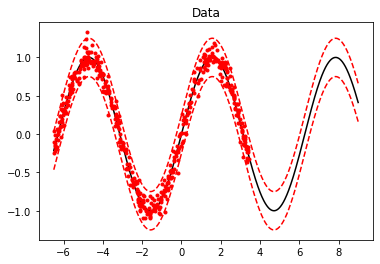

In [4]:
ntrain = 64*8
ntest = 1000
sigma = 0.1 # noise standard deviation

xtrain = torch.rand(ntrain) * 10 - 6.5
xtest = torch.linspace(-6.5, 9., ntest)
ε = sigma * torch.randn(xtrain.shape[0])

ytrain = torch.sin(xtrain) + ε
ytest = torch.sin(xtest)

plt.figure()
plt.plot(xtest, ytest, 'k')
plt.plot(xtrain, ytrain, '.r')
plt.plot(xtest, ytest+2.5*sigma, '--r')
plt.plot(xtest, ytest-2.5*sigma, '--r')
plt.title('Data');

In [5]:
train_dataset = TensorDataset(xtrain, ytrain)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [6]:
ypreds, ystds = {}, {}

## Deterministic Network

In [7]:
class DeepNetwork(nn.Module):
    def __init__(self, I, H, O, drop=0.3):
        super(DeepNetwork, self).__init__()
        self.net =  nn.Sequential(
            nn.Linear(I, H[0], bias=True),
            nn.ReLU(),
            nn.Linear(H[0], H[1], bias=True),
            nn.ReLU(),
            nn.Linear(H[1], O, bias=True))
        
    def forward(self, x):
        return self.net(x)

In [8]:
model = DeepNetwork(1, [20, 50], 1)
model

DeepNetwork(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)

Epoch: 0, Loss: 0.06033275090157986
Epoch: 500, Loss: 0.002540991597925313
Epoch: 1000, Loss: 0.001233811562997289
Epoch: 1500, Loss: 0.0012230765423737466
Epoch: 2000, Loss: 0.0011246114372625016
Epoch: 2500, Loss: 0.0011074323338107206
Epoch: 3000, Loss: 0.001136816237703897
Epoch: 3500, Loss: 0.0011185266266693361
Epoch: 4000, Loss: 0.0011437919893069193
Epoch: 4500, Loss: 0.0011770312921726145


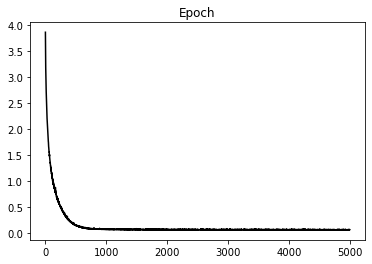

In [9]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.MSELoss()
n_epochs = 5000

model.train()
loss_hist = []
for epoch in range(n_epochs):
    total_loss = 0.
    for X, y in train_loader:
        optimizer.zero_grad()
        yest = model(X.view(X.shape[0], 1)).squeeze()
        loss = criterion(yest, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    loss_hist.append(total_loss)
    if epoch % (n_epochs//10) == 0:
        print(f'''Epoch: {epoch}, Loss: {total_loss / X.size(0)}''')
        
plt.figure()
plt.plot(loss_hist, 'k')
plt.title('Epoch');

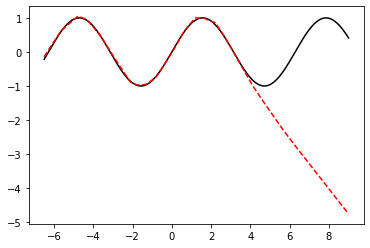

In [10]:
# Prediction
ypred = model(xtest.view(xtest.shape[0], 1)) 
ypreds['Deterministic'] = ypred

plt.figure()
plt.plot(xtest, ytest, 'k')
plt.plot(xtest, ypred.detach().numpy(), '--r');

## Network with Dropout UQ

In [11]:
class DeepDropNetwork(nn.Module):
    def __init__(self, I, H, O, drop=0.3):
        super(DeepDropNetwork, self).__init__()
        self.net =  nn.Sequential(
            nn.Linear(I, H[0], bias=True),
            nn.Dropout(p=drop),
            nn.ReLU(),
            nn.Linear(H[0], H[1], bias=True),
            nn.Dropout(p=drop),
            nn.ReLU(),
            nn.Linear(H[1], O, bias=True))
        
    def forward(self, x):
        return self.net(x)

In [12]:
model = DeepDropNetwork(1, [20, 50], 1, drop=0.01)
model

DeepDropNetwork(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Dropout(p=0.01, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=50, bias=True)
    (4): Dropout(p=0.01, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)

Epoch: 0, Loss: 0.053438459523022175
Epoch: 500, Loss: 0.005904383084271103
Epoch: 1000, Loss: 0.0023866397968959063
Epoch: 1500, Loss: 0.002072757139103487
Epoch: 2000, Loss: 0.001972118130652234
Epoch: 2500, Loss: 0.0018548647203715518
Epoch: 3000, Loss: 0.0021525937772821635
Epoch: 3500, Loss: 0.0019900686165783554
Epoch: 4000, Loss: 0.0018605671357363462
Epoch: 4500, Loss: 0.0020283856138121337


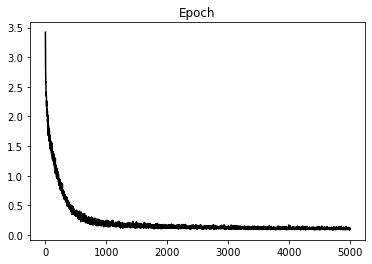

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.MSELoss()
n_epochs = 5000

model.train()
loss_hist = []
for epoch in range(n_epochs):
    total_loss = 0.
    for X, y in train_loader:
        optimizer.zero_grad()
        yest = model(X.view(X.shape[0], 1)).squeeze() 
        loss = criterion(yest, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    loss_hist.append(total_loss)
    if epoch % (n_epochs//10) == 0:
        print(f'''Epoch: {epoch}, Loss: {total_loss / X.size(0)}''')

plt.figure()
plt.plot(loss_hist, 'k')
plt.title('Epoch');

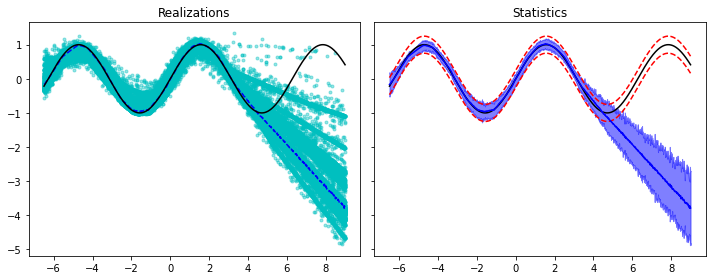

In [14]:
nreals = 400
yreals = np.hstack([model(xtest.view(xtest.shape[0], 1)).detach().numpy() for _ in range(nreals)])

ypred = yreals.mean(axis=1)
ystd = yreals.std(axis=1)
ypreds['Dropout'] = ypred
ystds['Dropout'] = ystd

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
axs[0].plot(xtest, yreals, '.c', alpha=0.4)
axs[0].plot(xtest, ypred, '--b')
axs[0].plot(xtest, ytest, 'k')
axs[0].set_title('Realizations')
axs[1].plot(xtest, ytest, 'k')
axs[1].plot(xtest, ytest+2.5*sigma, '--r')
axs[1].plot(xtest, ytest-2.5*sigma, '--r')
axs[1].plot(xtest, ypred, 'b')
axs[1].fill_between(xtest, ypred - 2.5*ystd, ypred + 2.5*ystd,
                    alpha=0.5, color='b')
axs[1].set_title('Statistics')
fig.tight_layout();

## Network with Distributional parameter UQ

In [15]:
model = DeepNetwork(1, [20, 50], 2)
model

DeepNetwork(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)

Epoch: 0, Loss: 0.1573436763137579
Epoch: 500, Loss: -0.02967595378868282
Epoch: 1000, Loss: -0.08636288624256849
Epoch: 1500, Loss: -0.10893704276531935
Epoch: 2000, Loss: -0.11273339204490185
Epoch: 2500, Loss: -0.10959562007337809
Epoch: 3000, Loss: -0.09271630458533764
Epoch: 3500, Loss: -0.11049120407551527
Epoch: 4000, Loss: -0.10189047176390886
Epoch: 4500, Loss: -0.10882386472076178


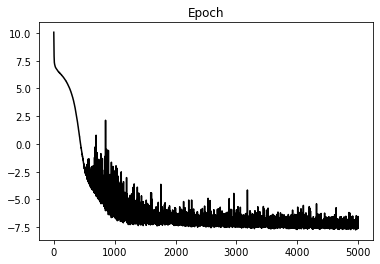

In [16]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
n_epochs = 5000

model.train()
loss_hist = []
for epoch in range(n_epochs):
    total_loss = 0.
    for X, y in train_loader:
        optimizer.zero_grad()
        yest = model(X.view(X.shape[0], 1)) 
        yestdistr = dd.Normal(yest[:, 0], torch.exp(yest[:, 1]))
        loss = -torch.mean(yestdistr.log_prob(y))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    loss_hist.append(total_loss)
    if epoch % (n_epochs//10) == 0:
        print(f'''Epoch: {epoch}, Loss: {total_loss / X.size(0)}''')

plt.figure()
plt.plot(loss_hist, 'k')
plt.title('Epoch');

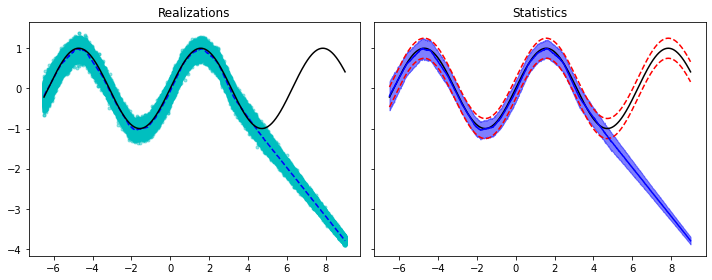

In [17]:
nreals = 400
yest = model(xtest.view(xtest.shape[0], 1))
mu, sig = yest[:, 0], torch.exp(yest[:, 1])
ydistr = dd.Normal(mu, sig)
yreals = ydistr.sample((nreals,)).T

ypred = yreals.mean(axis=1)
ystd = yreals.std(axis=1)
ypreds['DistrPar'] = ypred
ystds['DistrPar'] = ystd

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
axs[0].plot(xtest, yreals, '.c', alpha=0.4)
axs[0].plot(xtest, ypred, '--b')
axs[0].plot(xtest, ytest, 'k')
axs[0].set_title('Realizations')
axs[1].plot(xtest, ytest, 'k')
axs[1].plot(xtest, ytest+2.5*sigma, '--r')
axs[1].plot(xtest, ytest-2.5*sigma, '--r')
axs[1].plot(xtest, ypred, 'b')
axs[1].fill_between(xtest, ypred - 2.5*ystd, ypred + 2.5*ystd,
                    alpha=0.5, color='b')
axs[1].set_title('Statistics')
fig.tight_layout();

## Deep Ensemble Network UQ

Training model 0/10
Epoch: 0, Loss: 0.056441571563482285
Epoch: 200, Loss: 0.013227329589426517
Epoch: 400, Loss: 0.006249168538488448
Epoch: 600, Loss: 0.003216569632058963
Epoch: 800, Loss: 0.0020202498126309365
Epoch: 1000, Loss: 0.0016170852759387344
Epoch: 1200, Loss: 0.0012992800620850176
Epoch: 1400, Loss: 0.001295278882025741
Epoch: 1600, Loss: 0.0014155734097585082
Epoch: 1800, Loss: 0.001561226454214193
Training model 1/10
Epoch: 0, Loss: 0.04955064691603184
Epoch: 200, Loss: 0.009868560009635985
Epoch: 400, Loss: 0.0023472459870390594
Epoch: 600, Loss: 0.0013725922617595643
Epoch: 800, Loss: 0.0012138907186454162
Epoch: 1000, Loss: 0.0012118900049244985
Epoch: 1200, Loss: 0.0011830247822217643
Epoch: 1400, Loss: 0.0011951664564548992
Epoch: 1600, Loss: 0.001249042667041067
Epoch: 1800, Loss: 0.0011374029345461167
Training model 2/10
Epoch: 0, Loss: 0.05348010500892997
Epoch: 200, Loss: 0.00820277800085023
Epoch: 400, Loss: 0.0022984301613178104
Epoch: 600, Loss: 0.0012926618

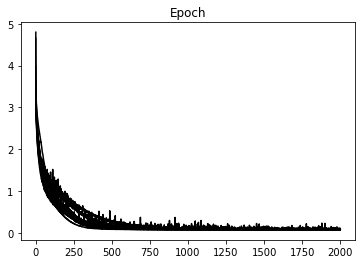

In [18]:
criterion = torch.nn.MSELoss()
n_epochs = 2000
n_models = 10

models = []
loss_hists = []
for i in range(n_models):
    print(f'Training model {i}/{n_models}')
    model = DeepNetwork(1, [20, 50], 1)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

    model.train()
    loss_hist = []
    for epoch in range(n_epochs):
        total_loss = 0.
        for X, y in train_loader:
            optimizer.zero_grad()
            yest = model(X.view(X.shape[0], 1)).squeeze()
            loss = criterion(yest, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        loss_hist.append(total_loss)
        if epoch % (n_epochs//10) == 0:
            print(f'Epoch: {epoch}, Loss: {total_loss / X.size(0)}')
    loss_hists.append(loss_hist)
    models.append(model)
    
plt.figure()
plt.plot(np.array(loss_hists).T, 'k')
plt.title('Epoch');

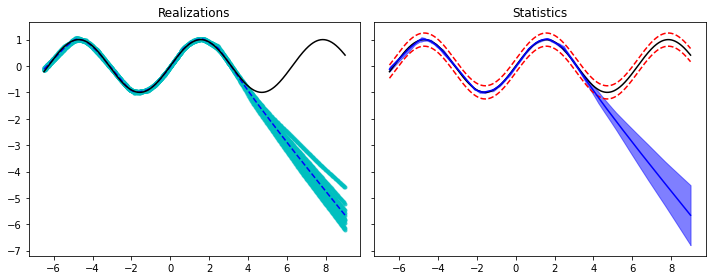

In [19]:
# Prediction
yreals = np.hstack([model(xtest.view(xtest.shape[0], 1)).detach().numpy() for model in models])

ypred = yreals.mean(axis=1)
ystd = yreals.std(axis=1)
ypreds['Ensemble'] = ypred
ystds['Ensemble'] = ystd

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
axs[0].plot(xtest, yreals, '.c', alpha=0.4)
axs[0].plot(xtest, ypred, '--b')
axs[0].plot(xtest, ytest, 'k')
axs[0].set_title('Realizations')
axs[1].plot(xtest, ytest, 'k')
axs[1].plot(xtest, ytest+2.5*sigma, '--r')
axs[1].plot(xtest, ytest-2.5*sigma, '--r')
axs[1].plot(xtest, ypred, 'b')
axs[1].fill_between(xtest, ypred - 2.5*ystd, ypred + 2.5*ystd,
                    alpha=0.5, color='b')
axs[1].set_title('Statistics')
fig.tight_layout();

## Bayesian Network

In [20]:
class BayesianNetwork(nn.Module):
    def __init__(self, I, H, O):
        super(BayesianNetwork, self).__init__()
        self.net =  nn.Sequential(
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=I, out_features=H[0]),
            nn.ReLU(),
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=H[0], out_features=H[1]),
            nn.ReLU(),
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=H[1], out_features=O))
        
    def forward(self, x):
        return self.net(x)

In [21]:
model = BayesianNetwork(1, [20, 50], 1)
model

BayesianNetwork(
  (net): Sequential(
    (0): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=20, bias=True)
    (1): ReLU()
    (2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=50, bias=True)
    (3): ReLU()
    (4): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=50, out_features=1, bias=True)
  )
)

Epoch: 0, Loss: 0.4886898994445801, MSE: 0.47464585304260254, KL: 1.404404640197754
Epoch: 500, Loss: 0.09646101295948029, MSE: 0.07975506782531738, KL: 1.670594334602356
Epoch: 1000, Loss: 0.1044982448220253, MSE: 0.08891656249761581, KL: 1.5581680536270142
Epoch: 1500, Loss: 0.03265533968806267, MSE: 0.016974566504359245, KL: 1.5680774450302124
Epoch: 2000, Loss: 0.03826425224542618, MSE: 0.023716917261481285, KL: 1.4547337293624878
Epoch: 2500, Loss: 0.026146862655878067, MSE: 0.012891283258795738, KL: 1.3255579471588135
Epoch: 3000, Loss: 0.02823568508028984, MSE: 0.01619730331003666, KL: 1.2038382291793823
Epoch: 3500, Loss: 0.02655787393450737, MSE: 0.015229551121592522, KL: 1.1328322887420654
Epoch: 4000, Loss: 0.020889975130558014, MSE: 0.010063198395073414, KL: 1.0826776027679443
Epoch: 4500, Loss: 0.021039817482233047, MSE: 0.010568194091320038, KL: 1.0471622943878174


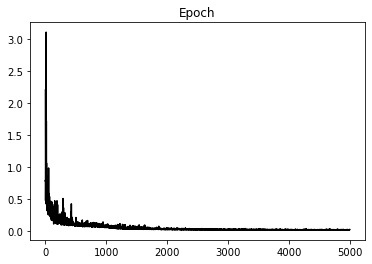

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01
n_epochs = 5000

model.train()
loss_hist = []
for epoch in range(n_epochs):
    optimizer.zero_grad()
    yest = model(xtrain.view(xtrain.shape[0], 1)).squeeze() 
    mse = mse_loss(yest, ytrain)
    kl = kl_loss(model)
    loss = mse + kl_weight*kl
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.item())
    
    if epoch % (n_epochs//10) == 0:
        print(f'''Epoch: {epoch}, Loss: {loss.item()}, MSE: {mse.item()}, KL: {kl.item()}''')

plt.figure()
plt.plot(loss_hist, 'k')
plt.title('Epoch');

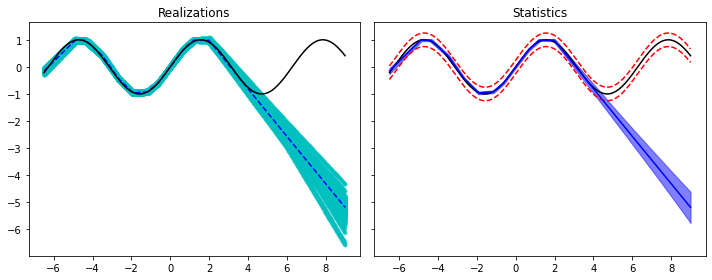

In [23]:
# Prediction
nreals = 400
yreals = np.hstack([model(xtest.view(xtest.shape[0], 1)).detach().numpy() for _ in range(nreals)])

ypred = yreals.mean(axis=1)
ystd = yreals.std(axis=1)
ypreds['BayesianNN'] = ypred
ystds['BayesianNN'] = ystd

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
axs[0].plot(xtest, yreals, '.c', alpha=0.4)
axs[0].plot(xtest, ypred, '--b')
axs[0].plot(xtest, ytest, 'k')
axs[0].set_title('Realizations')
axs[1].plot(xtest, ytest, 'k')
axs[1].plot(xtest, ytest+2.5*sigma, '--r')
axs[1].plot(xtest, ytest-2.5*sigma, '--r')
axs[1].plot(xtest, ypred, 'b')
axs[1].fill_between(xtest.squeeze(), ypred - 2.5*ystd, ypred + 2.5*ystd,
                    alpha=0.5, color='b')
axs[1].set_title('Statistics')
fig.tight_layout();

Finally, let's compare the different predictions (and their uncertainties)

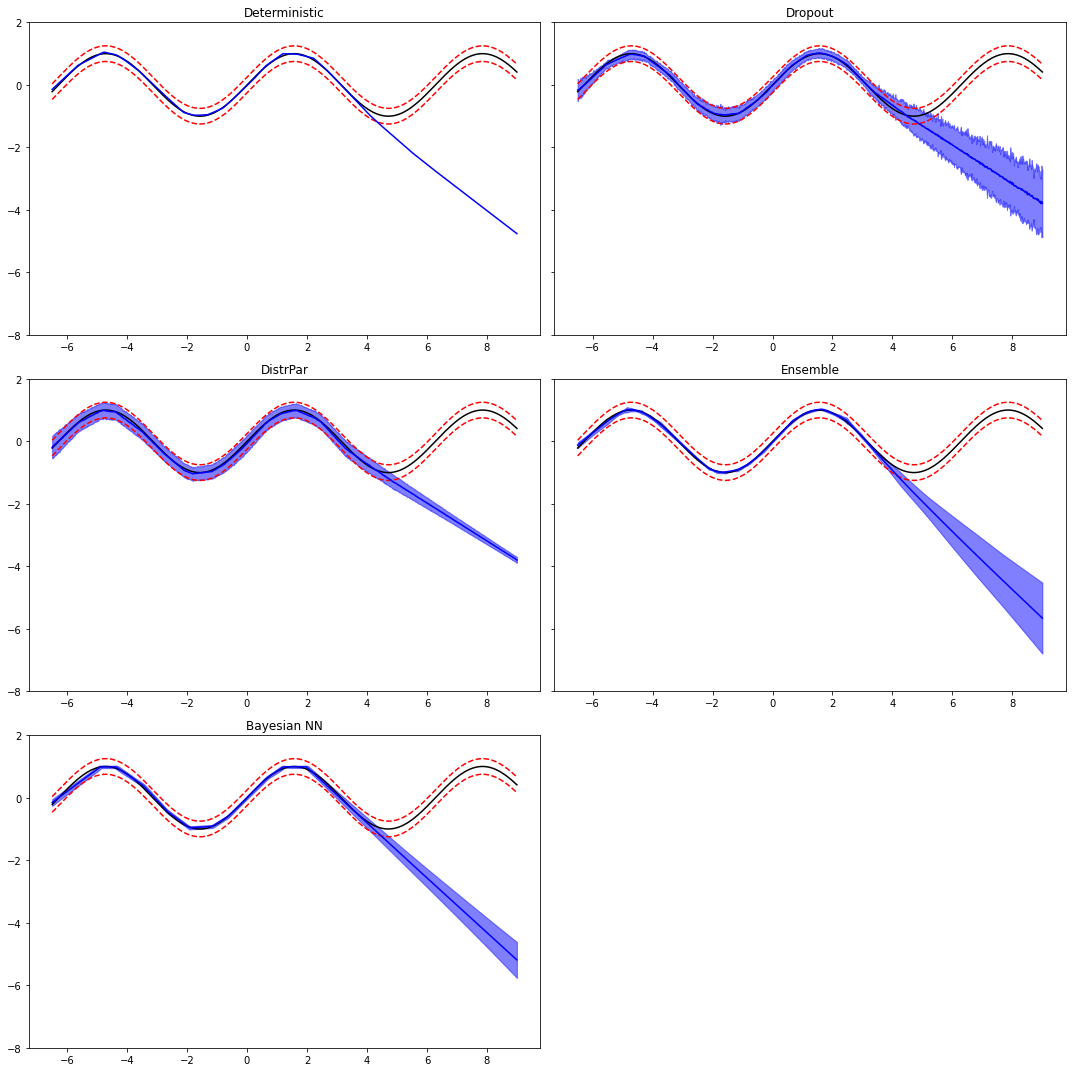

In [27]:
fig, axs = plt.subplots(3, 2, sharey=True, figsize=(15, 15))
axs[0][0].plot(xtest, ytest, 'k')
axs[0][0].plot(xtest, ytest+2.5*sigma, '--r')
axs[0][0].plot(xtest, ytest-2.5*sigma, '--r')
axs[0][0].plot(xtest, ypreds['Deterministic'].detach().numpy(), 'b')
axs[0][0].set_title('Deterministic')
axs[0][1].plot(xtest, ytest, 'k')
axs[0][1].plot(xtest, ytest+2.5*sigma, '--r')
axs[0][1].plot(xtest, ytest-2.5*sigma, '--r')
axs[0][1].plot(xtest, ypreds['Dropout'], 'b')
axs[0][1].fill_between(xtest, ypreds['Dropout'] - 2.5*ystds['Dropout'], 
                       ypreds['Dropout'] + 2.5*ystds['Dropout'],
                       alpha=0.5, color='b')
axs[0][1].set_title('Dropout')
axs[1][0].plot(xtest, ytest, 'k')
axs[1][0].plot(xtest, ytest+2.5*sigma, '--r')
axs[1][0].plot(xtest, ytest-2.5*sigma, '--r')
axs[1][0].plot(xtest, ypreds['DistrPar'], 'b')
axs[1][0].fill_between(xtest, ypreds['DistrPar'] - 2.5*ystds['DistrPar'], 
                       ypreds['DistrPar'] + 2.5*ystds['DistrPar'],
                       alpha=0.5, color='b')
axs[1][0].set_title('DistrPar')
axs[1][1].plot(xtest, ytest, 'k')
axs[1][1].plot(xtest, ytest+2.5*sigma, '--r')
axs[1][1].plot(xtest, ytest-2.5*sigma, '--r')
axs[1][1].plot(xtest, ypreds['Ensemble'], 'b')
axs[1][1].fill_between(xtest, ypreds['Ensemble'] - 2.5*ystds['Ensemble'], 
                       ypreds['Ensemble'] + 2.5*ystds['Ensemble'],
                       alpha=0.5, color='b')
axs[1][1].set_title('Ensemble')
axs[2][0].plot(xtest, ytest, 'k')
axs[2][0].plot(xtest, ytest+2.5*sigma, '--r')
axs[2][0].plot(xtest, ytest-2.5*sigma, '--r')
axs[2][0].plot(xtest, ypreds['BayesianNN'], 'b')
axs[2][0].fill_between(xtest, ypreds['BayesianNN'] - 2.5*ystds['BayesianNN'], 
                       ypreds['BayesianNN'] + 2.5*ystds['BayesianNN'],
                       alpha=0.5, color='b')
axs[2][0].set_title('Bayesian NN')
axs[0][0].set_ylim(-8, 2)
axs[2][1].axis('off')
fig.tight_layout();